In [16]:
import pypsa
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline



In [17]:
hourly_index = pd.date_range("2025-03-01 00:00", "2025-03-01 23:00", freq="h", tz="Australia/Brisbane")
    
# Create hourly data
hourly_usage = pd.Series([0.0] * 7 + [9.0] * 2 + [0.0] * 8 + [9.0] * 2 + [0.0] * 5, hourly_index)

# Resample to 5-minute intervals and forward fill
bev_usage = hourly_usage.resample("5min").ffill()

five_minute_index = pd.date_range("2025-03-01 00:00", "2025-03-01 23:55", freq="5min", tz="Australia/Brisbane")

work_charger_p_max_pu = pd.Series(0, five_minute_index)
work_charger_p_max_pu["2025-03-01 09:00:00+10:00":"2025-03-01 17:00:00+10:00"] = 0.5

home_charger_p_max_pu = pd.Series(0.8, five_minute_index)
home_charger_p_max_pu["2025-03-01 09:00:00+10:00":"2025-03-01 17:00:00+10:00"] = 0.2
# Create a new network
network = pypsa.Network()

hourly_marginal_grid_price = pd.Series(
    [70.0] * 6 + # 0 - 6am
    [120.0] * 2 + # 6 - 8am
    [30.0] * 2 + # 8 - 10am
    [15.0] * 5 + # 10 - 3pm
    [40.0] * 1 + # 3 - 4pm
    [80.0] * 1 + # 4 - 5pm
    [100.0] * 1 + # 5 - 6pm
    [120.0] * 1 + # 6 - 7pm
    [110.0] * 1 + # 7 - 8pm
    [95.0] * 2 + # 8 - 10pm
    [75.0] * 2 # 10 - 12pm
    , hourly_index)

hourly_marginal_grid_price = hourly_marginal_grid_price.resample("5min").ffill()
# print(network.snapshots)
network.add("Bus", "place of work", marginal_price=hourly_marginal_grid_price, carrier="AC", v_nom=240)

/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/ipykernel_31404/3681638879.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  work_charger_p_max_pu["2025-03-01 09:00:00+10:00":"2025-03-01 17:00:00+10:00"] = 0.5


In [18]:

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from gridsim_backend.app.network import get_single_node_network

n = get_single_node_network()
n.optimize()
print('objective', n.objective)
print('statistics', n.statistics())




/Users/eddiesholl/Code/eddiesholl/gridsim/backend/gridsim_backend/app/network.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  work_charger_p_max_pu["2025-03-01 09:00":"2025-03-01 17:00"] = 0.5
Index(['grid'], dtype='object', name='Generator')
Index(['work charger', 'home charger'], dtype='object', name='Link')
Index(['grid_place_of_work', 'grid_home'], dtype='object', name='Line')
Index(['grid_place_of_work', 'grid_home'], dtype='object', name='Line')
Index(['battery storage'], dtype='object', name='Store')
Index(['place of work', 'home', 'grid', 'battery'], dtype='object', name='Bus')
Index(['grid'], dtype='object', name='Generator')
Index(['work charger', 'home charger'], dtype='object', name='Link')
Index(['grid_place_of_work', 'grid_home'], dtype='object', name='Line')
Index(['grid_place_of_work', 'grid

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 1e+00]
  Cost   [2e+01, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [4e+00, 1e+03]
Presolving model
384 rows, 768 cols, 1151 nonzeros  0s
148 rows, 473 cols, 620 nonzeros  0s
67 rows, 392 cols, 458 nonzeros  0s
50 rows, 104 cols, 153 nonzeros  0s
49 rows, 99 cols, 147 nonzeros  0s
Presolve : Reductions: rows 49(-4847); columns 99(-1917); elements 147(-7052)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
         63     2.7177777778e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 63
Objective value     :  2.7177777778e+04
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/linopy-solve-z8x2eg92.sol
objectiv

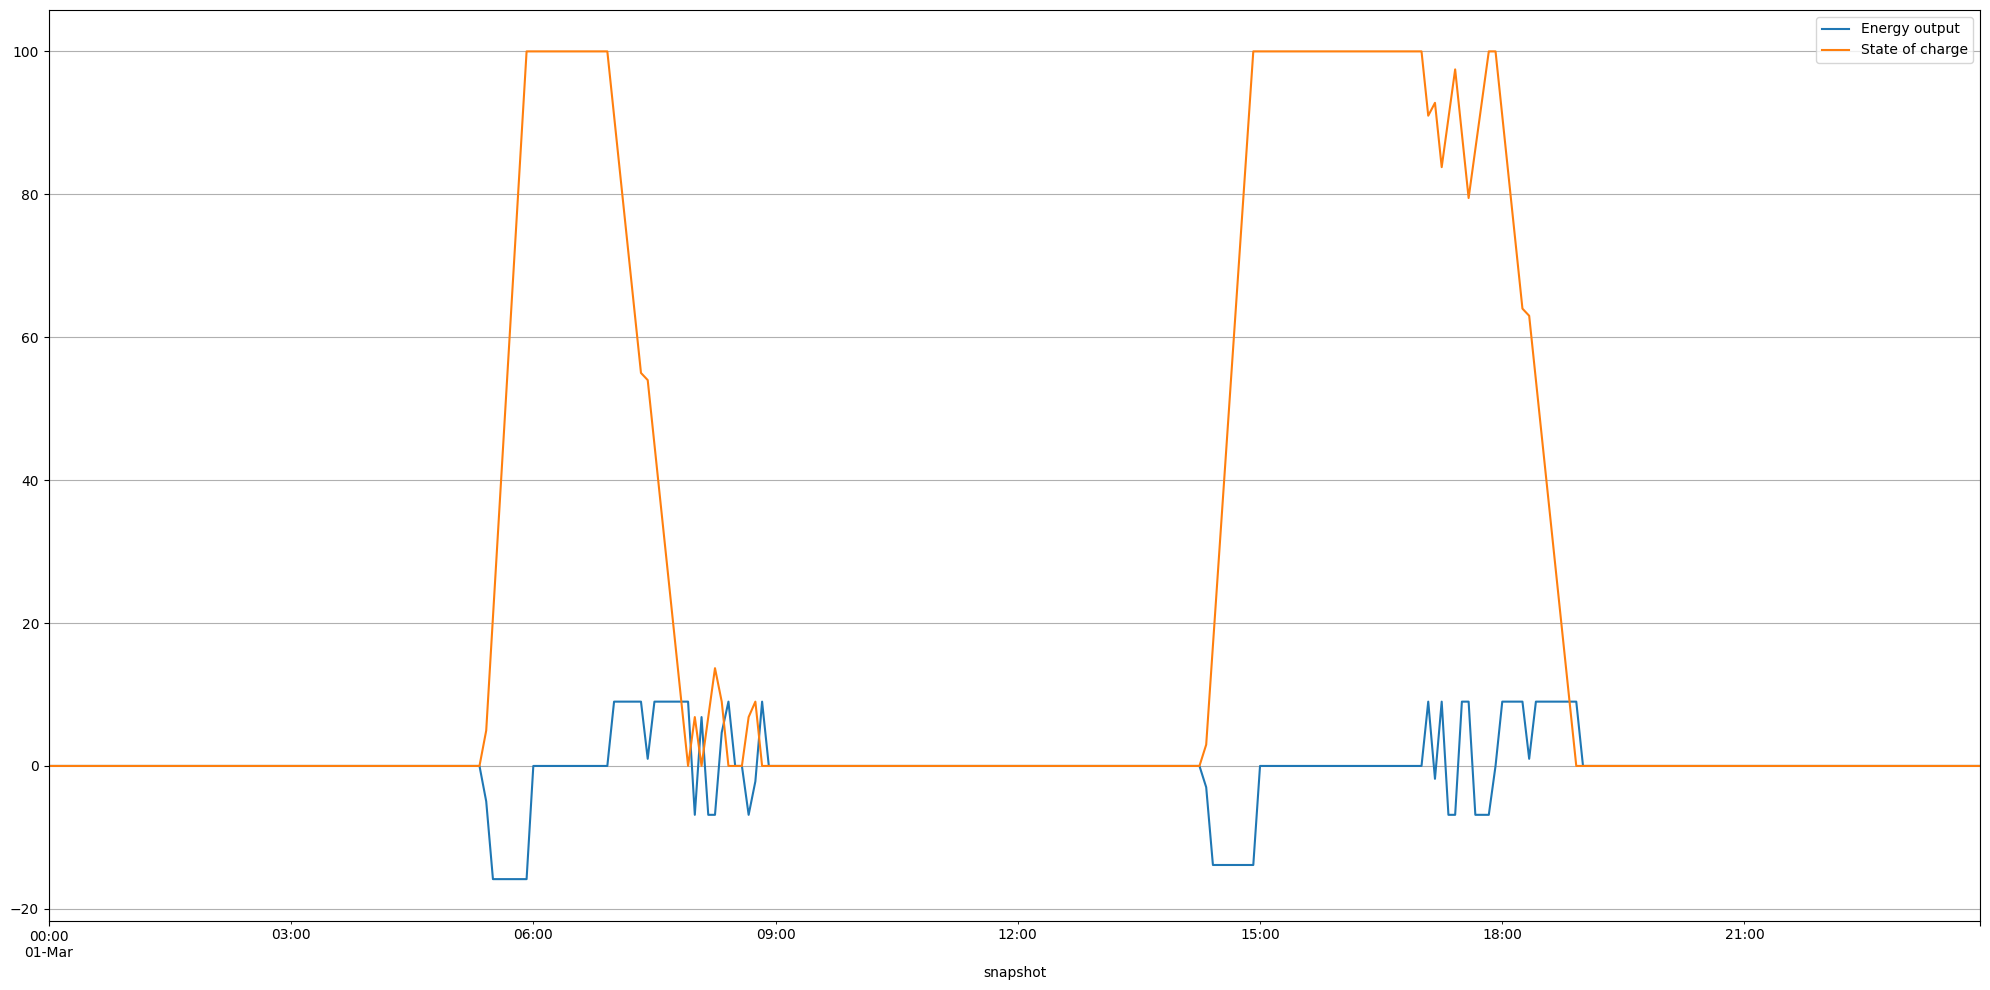

In [19]:
df = pd.DataFrame(
    {attr: n.stores_t[attr]["battery storage"] for attr in ["p", "e"]}
)
df.plot(grid=True, figsize=(20, 10))
plt.legend(labels=["Energy output", "State of charge"])
plt.tight_layout()